In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from fuzzywuzzy import process
from rapidfuzz import process
import re


/home/fabien/Bureau/VSCode/dsfs-ft-32/Projets/fab_book_recommender/.venv/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Ouverture-conversion des fichiers csv source
df_ratings = pd.read_csv('../data/Ratings.csv')
df_users = pd.read_csv('../data/Users.csv')
df_books = pd.read_csv('../data/Books.csv',  dtype={3: str})

In [5]:
# Gestion des ISBN erronés
def clean_isbn(df, name):
    # Vérifier les ISBN de 10 caractères (y compris ceux avec un 'X')
    isbn_10_valid = df['ISBN'].str.match(r'^[0-9]{9}[0-9Xx]$', na=False)
    
    #Vérifier les ISBN de 13 caractères (uniquement des chiffres)
    isbn_13_valid = df['ISBN'].str.match(r'^[0-9]{13}$', na=False)

    #Sélectionner uniquement les lignes avec des ISBN valides
    valid_isbn_df = df[isbn_10_valid | isbn_13_valid]

    #Afficher avant et après nettoyage
    print(f"Avant nettoyage (total lignes): {len(df)}")
    print(f"Après nettoyage (total lignes): {len(valid_isbn_df)}")
    print(f"Lignes supprimées : {len(df) - len(valid_isbn_df)}")

    #Retourner le DataFrame nettoyé
    return valid_isbn_df

---
** Ratings

- pas de valeurs manquantes
- suppression des notes à 0 (prédominance 2/3 1/3)

In [6]:
# Correction des ISBN
df_ratings = clean_isbn(df_ratings, "df_ratings")

Avant nettoyage (total lignes): 1149780
Après nettoyage (total lignes): 1139570
Lignes supprimées : 10210


In [7]:
# Test valeurs manquantes
print(df_ratings.shape)

print(df_ratings.isna().value_counts())
display(df_ratings.head())

(1139570, 3)
User-ID  ISBN   Book-Rating
False    False  False          1139570
Name: count, dtype: int64


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


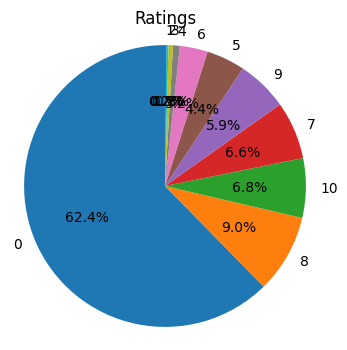

In [8]:
# Distribution des ratings
plt.figure(figsize=(4, 4))
value_counts = df_ratings['Book-Rating'].value_counts()
plt.pie(value_counts,
        labels=value_counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
plt.title('Ratings')
plt.axis('equal')
plt.show()

In [9]:
# Suppression des ratings = 0
count = len(df_ratings)
mask = df_ratings['Book-Rating'] == 0
df_ratings = df_ratings.loc[~mask]
count -= len(df_ratings)

print(f'lignes supprimées : {count}')
print(df_ratings.shape)
display(df_ratings.head())

lignes supprimées : 710552
(429018, 3)


,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


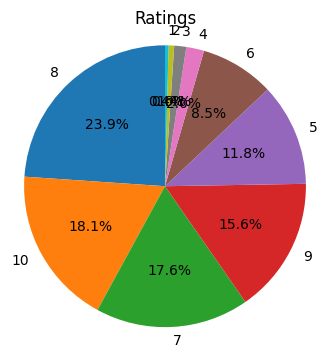

In [10]:
# Distribution des ratings après suppression des 0
plt.figure(figsize=(4, 4))
value_counts = df_ratings['Book-Rating'].value_counts()
plt.pie(value_counts,
        labels=value_counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
plt.title('Ratings')
plt.axis('equal')
plt.show()

---
** Users

test des valeurs manquantes : 40% d'âges non renseignés. La colonne sera ignorée

In [12]:
# Pourcentage de valeurs manquantes
print(df_users.shape)
# test valeurs manquantes
print(df_users.isna().value_counts())
display(df_users.head())

percentage_NaN = df_users['Age'].isna().mean()*100
print(f'Pourcentage de NaN dans la colonne Age: {percentage_NaN:.2f}%')

(278858, 3)
User-ID  Location  Age  
False    False     False    168096
                   True     110762
Name: count, dtype: int64


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Pourcentage de NaN dans la colonne Age: 39.72%


---
** Books

In [13]:
print(df_books.shape)
display(df_books.head())

(271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [14]:
# Correction des ISBN
df_books = clean_isbn(df_books, "df_books")

Avant nettoyage (total lignes): 271360
Après nettoyage (total lignes): 271242
Lignes supprimées : 118


In [15]:
# Fonction de nettoyage du titre
def extract_main_title(title):
    if not isinstance(title, str):
        return title  # Ignorer les valeurs non textuelles

    # Trouver la première occurrence de ':' ou '(' et conserver ce qui précède
    match = re.split(r'[(]', title, maxsplit=1)
    main_title = match[0].strip() if match else title
    return main_title

In [16]:
print('Nombre de livres différents :', len(df_books['Book-Title'].unique()))
df_books["Book-Title"] = df_books["Book-Title"].apply(extract_main_title)
print('Nombre de livres différents :', len(df_books['Book-Title'].unique()))
df_books.head()

Nombre de livres différents : 242087
Nombre de livres différents : 226432


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [17]:
# Valeurs manquantes
print(df_books.shape)
# test valeurs manquantes
print(df_books.isna().value_counts())

(271242, 8)
ISBN   Book-Title  Book-Author  Year-Of-Publication  Publisher  Image-URL-S  Image-URL-M  Image-URL-L
False  False       False        False                False      False        False        False          271235
                                                                                          True                3
                                                     True       False        False        False               2
                   True         False                False      False        False        False               2
Name: count, dtype: int64


In [18]:
# Valeurs manquantes dans la colonne Image-URL-L
mask = df_books['Image-URL-L'].isna()
display(df_books.loc[mask, :])
# Imputation par la valeur de la colonne Image-URL-M
df_books.loc[mask, 'Image-URL-L'] = df_books.loc[mask, 'Image-URL-M']
display(df_books.loc[mask, :])

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...


In [19]:
# Valeurs manquantes dans la colonne Publisher
mask = df_books['Publisher'].isna()
display(df_books.loc[mask, :])
# Imputation par la valeur recherchée sur le Web pour Tyrant Moon (ISBN conforme) : Novelbooks Inc
df_books.loc[df_books['ISBN'] == '193169656X', 'Publisher'] = 'Novelbooks Inc'
# Imputation par la valeur recherchée sur le Web pour Finders Keepers : Bantam
df_books.loc[df_books['ISBN'] == '1931696993', 'Publisher'] = 'Bantam'
#display(df_books.loc[mask, :])

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [20]:
# Valeurs manquantes dans la colonne Book-Author
mask = df_books['Book-Author'].isna()
display(df_books.loc[mask, :])
# drop de la ligne
df_books = df_books.loc[~mask, :]
display(df_books.loc[mask, :])

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


---
** Dataset

---
** Fusion des datasets inviduels

In [21]:
# Fusion des datasets inviduels
df_usersbyratings = pd.merge(df_ratings, df_users, on='User-ID')
dataset = pd.merge(df_books, df_usersbyratings, on='ISBN')
del(df_usersbyratings)
display(dataset.head(5))

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8,"n/a, n/a, n/a",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,67544,8,"toronto, ontario, canada",30.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,116866,9,"ottawa, ,",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,123629,9,"kingston, ontario, canada",NaN


---
** EDA

In [22]:
# Sélection de colonnes du dataset
l_columns = ['ISBN', 'Book-Title', 'Book-Author', 'Publisher',
             'Book-Rating', 'Location',
       'Image-URL-L', 'User-ID', ]  #'Image-URL-S', 'Image-URL-M', 
dataset = dataset.loc[:, l_columns]

In [23]:
# Recherche des valeurs manquantes : il n'y en a plus à ce niveau
dataset.isna().value_counts()

ISBN   Book-Title  Book-Author  Publisher  Book-Rating  Location  Image-URL-L  User-ID
False  False       False        False      False        False     False        False      383783
Name: count, dtype: int64

In [24]:
# Filtre sur Location : ne garder que les Location renseignées, ou avec un Country, au minimum
empty_locations = dataset['Location'].isna() \
                | (dataset['Location'] == '') \
                | (dataset['Location'].str.contains('n/a', case=False, na=False) \
                | (dataset['Location'].str.split(',').str[2].str.strip() == '') \
                )
count = empty_locations.sum()

print(dataset.shape)
print(f'lignes supprimées : {count}')
# On droppe les location non renseignées
dataset = dataset.loc[~empty_locations, :]
print(dataset.shape)

(383783, 8)
lignes supprimées : 23149
(360634, 8)


In [25]:
# Creation d'une colonne country
dataset['Country'] = dataset['Location'].str.split(',').str[2].str.strip()
print(dataset.shape)
display(dataset.head())

(360634, 9)


,ISBN,Book-Title,Book-Author,Publisher,Book-Rating,Location,Image-URL-L,User-ID,Country
0,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,5,"timmins, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,8,canada
2,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"toronto, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,67544,canada
4,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"kingston, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,123629,canada
5,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"comber, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,200273,canada
6,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"guelph, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,210926,canada


In [26]:
print(dataset.columns)
print(dataset.dtypes)
print(dataset.shape)

Index(['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Book-Rating',
       'Location', 'Image-URL-L', 'User-ID', 'Country'],
      dtype='object')
ISBN           object
Book-Title     object
Book-Author    object
Publisher      object
Book-Rating     int64
Location       object
Image-URL-L    object
User-ID         int64
Country        object
dtype: object
(360634, 9)


Nombre de publishers différents : 11132


/tmp/ipykernel_54801/1125087513.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_publishers, x="Publisher", y="Book-Title", palette="colorblind")


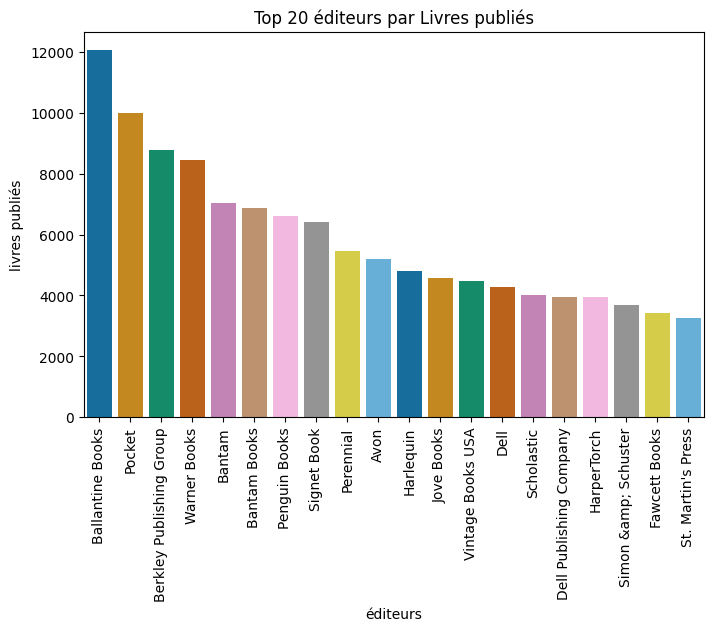

In [27]:
# Nombre de publishers différents
num_publishers = dataset["Publisher"].nunique()
print(f"Nombre de publishers différents : {num_publishers}")

publishers_count = dataset.groupby("Publisher")["Book-Title"].count().reset_index()

publishers_count = publishers_count.sort_values(by="Book-Title", ascending=False)
top_20_publishers = publishers_count.head(20)

# Visualisation avec Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=top_20_publishers, x="Publisher", y="Book-Title", palette="colorblind")
plt.title("Top 20 éditeurs par Livres publiés")
plt.xlabel("éditeurs")
plt.ylabel("livres publiés")
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_54801/1512736013.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_countries, x="Country", y="Book-Rating", palette="colorblind")


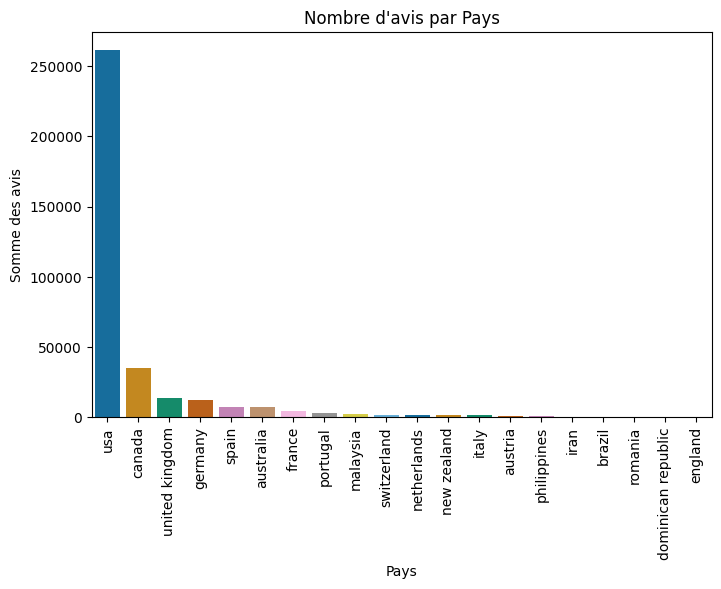

In [28]:
# Regroupement par pays et comptage des notes
country_ratings = dataset.groupby("Country")["Book-Rating"].count().reset_index()
country_ratings = country_ratings.sort_values(by="Book-Rating", ascending=False)

top_20_countries = country_ratings.head(20)

# Visualisation avec Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=top_20_countries, x="Country", y="Book-Rating", palette="colorblind")
plt.title("Nombre d'avis par Pays")
plt.xlabel("Pays")
plt.ylabel("Somme des avis")
plt.xticks(rotation=90)
plt.show()

In [29]:
# Filtre par continent : USA + Canada
count = len(dataset)
mask = (dataset['Country'].str.lower() == 'usa') | (dataset['Country'].str.lower() == 'canada')
dataset = dataset.loc[mask]
count -= len(dataset)
print(f'lignes supprimées : {count}')
print(dataset.shape)

lignes supprimées : 64004
(296630, 9)


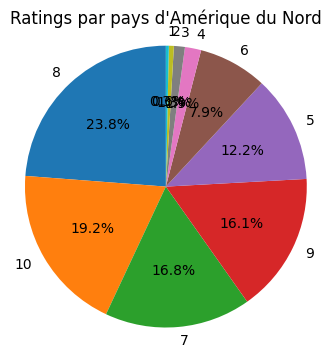

In [30]:
# Ratings pour les pays d'Amérique du Nord
plt.figure(figsize=(4, 4))
value_counts = dataset['Book-Rating'].value_counts()
plt.pie(value_counts,
        labels=value_counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
plt.title('Ratings par pays d\'Amérique du Nord')
plt.axis('equal')
plt.show()

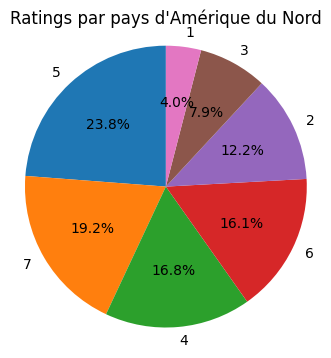

In [31]:
# Fusion des ratings 1,2,3,4
# Définir une fonction de mapping
def map_ratings(rating):
    if rating in [1, 2, 3, 4]:
        return 1
    elif rating in [5]:
        return 2
    elif rating in [6]:
        return 3
    elif rating in [7]:
        return 4
    elif rating in [8]:
        return 5
    elif rating in [9]:
        return 6
    else:   #rating == 9, 10
        return 7
dataset['New-Rating'] = dataset["Book-Rating"].apply(map_ratings)

plt.figure(figsize=(4, 4))
value_counts = dataset['New-Rating'].value_counts()
plt.pie(value_counts,
        labels=value_counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
plt.title('Ratings par pays d\'Amérique du Nord')
plt.axis('equal')
plt.show()

/tmp/ipykernel_54801/1581394796.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_users, x="User-ID", y="New-Rating", palette="colorblind")


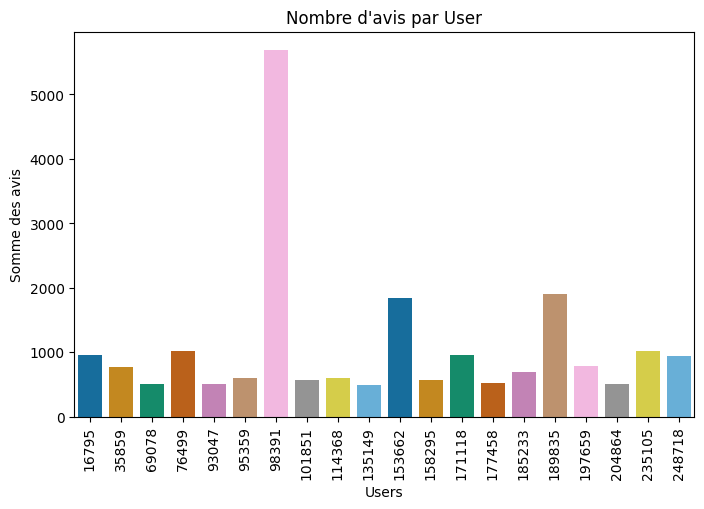

In [32]:
# Avis par utilisateurs
user_ratings = dataset.groupby("User-ID")["New-Rating"].count().reset_index()
user_ratings = user_ratings.sort_values(by="New-Rating", ascending=False)

top_20_users = user_ratings.head(20)

# Visualisation avec Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=top_20_users, x="User-ID", y="New-Rating", palette="colorblind")
plt.title("Nombre d'avis par User")
plt.xlabel("Users")
plt.ylabel("Somme des avis")
plt.xticks(rotation=90)
plt.show()

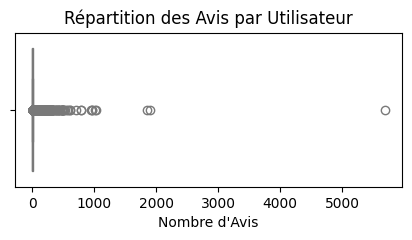

In [33]:
# Regrouper par User-ID et compter le nombre d'avis donnés
user_ratings_count = dataset.groupby("User-ID")["New-Rating"].count()


# Visualisation avec une box plot
plt.figure(figsize=(5, 2))
sns.boxplot(x=user_ratings_count, color="lightblue")
plt.title("Répartition des Avis par Utilisateur")
plt.xlabel("Nombre d'Avis")
plt.show()


In [34]:
# Affichage des User-ID par ordre de leur nombre de ratings décroissant
dataset.groupby("User-ID")["New-Rating"].count().sort_values(ascending=False).head(30)

User-ID
98391     5691
189835    1899
153662    1845
235105    1020
76499     1012
171118     962
16795      959
248718     941
197659     781
35859      777
185233     698
95359      606
114368     603
158295     567
101851     563
177458     524
204864     504
93047      501
69078      499
135149     487
100906     483
107784     482
23872      478
257204     475
60244      475
189334     470
123883     453
88733      437
129074     434
87141      424
Name: New-Rating, dtype: int64

lignes supprimées : 20453
(276177, 10)


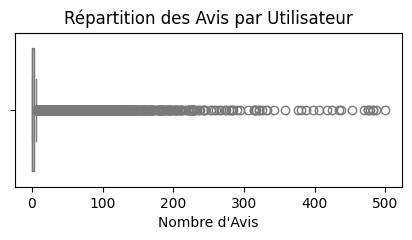

In [35]:
# Suppression des outliers (=users avec plus de 500 ratings)
# filtre du dataset avec uniquement les users ayant donné plus de 500 ratings
count = len(dataset)
user_in_a_range_of_ratings = user_ratings_count.loc[(user_ratings_count>0) & (user_ratings_count<=500)].index
dataset = dataset.loc[dataset['User-ID'].isin(user_in_a_range_of_ratings)]
count -= len(dataset)

print(f'lignes supprimées : {count}')
print(dataset.shape)

# Visualisation
# Regrouper par User-ID et compter le nombre d'avis donnés
user_ratings_count = dataset.groupby("User-ID")["New-Rating"].count()

# Visualisation avec une box plot
plt.figure(figsize=(5, 2))
sns.boxplot(x=user_ratings_count, color="lightblue")
plt.title("Répartition des Avis par Utilisateur")
plt.xlabel("Nombre d'Avis")
plt.show()

In [36]:
# Statistiques sur les ratings utilisateur
print(user_ratings_count.shape)
user_ratings_count.describe()

(50136,)


count    50136.000000
mean         5.508557
std         18.370919
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        499.000000
Name: New-Rating, dtype: float64

In [37]:
# Calcul de la moyenne des 'New-Rating' groupée par 'Book-Title' : nouvelle colonne Weighted-Rating
dataset['Weighted-Rating'] = dataset.groupby('Book-Title')['New-Rating'].transform('mean')
dataset.head(5)

,ISBN,Book-Title,Book-Author,Publisher,Book-Rating,Location,Image-URL-L,User-ID,Country,New-Rating,Weighted-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,5,"timmins, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,8,canada,2,4.428571
2,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"toronto, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,67544,canada,5,4.428571
4,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"kingston, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,123629,canada,6,4.428571
5,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"comber, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,200273,canada,5,4.428571
6,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"guelph, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,210926,canada,6,4.428571


In [40]:
# Nombre de livres différents
print('Nombre de livres différents :', len(dataset['Book-Title'].unique()))
dataset.head()

Nombre de livres différents : 89388


,ISBN,Book-Title,Book-Author,Publisher,Book-Rating,Location,Image-URL-L,User-ID,Country,New-Rating,Weighted-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,5,"timmins, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,8,canada,2,4.428571
2,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"toronto, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,67544,canada,5,4.428571
4,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"kingston, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,123629,canada,6,4.428571
5,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"comber, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,200273,canada,5,4.428571
6,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"guelph, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,210926,canada,6,4.428571


In [41]:
# Filtre des livres selon l'édition qui contient le plus grand nombre de ratings = l'édition la plus notée
dataset['Rating-Count'] = dataset.groupby('ISBN')['New-Rating'].transform('count')

# Trouver l'ISBN avec le plus grand nombre de ratings pour chaque Book-Title
isbn_of_most_rated_title = dataset.loc[dataset.groupby('Book-Title')['Rating-Count']\
                                .idxmax()]['ISBN'].values

# Filtrer le DataFrame pour conserver toutes les lignes ayant ces ISBN
most_rated_edition_per_book = dataset[dataset['ISBN'].isin(isbn_of_most_rated_title)]


print(most_rated_edition_per_book.shape)

count = len(dataset)
print(dataset.shape)
dataset = most_rated_edition_per_book
count -= len(dataset)
print(f'lignes supprimées : {count}')
print(dataset.shape)
dataset.head(15)


(237071, 12)
(276177, 12)
lignes supprimées : 39106
(237071, 12)


,ISBN,Book-Title,Book-Author,Publisher,Book-Rating,Location,Image-URL-L,User-ID,Country,New-Rating,Weighted-Rating,Rating-Count
0,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,5,"timmins, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,8,canada,2,4.428571,7
2,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"toronto, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,67544,canada,5,4.428571,7
4,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"kingston, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,123629,canada,6,4.428571,7
5,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,"comber, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,200273,canada,5,4.428571,7
6,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,9,"guelph, ontario, canada",http://images.amazon.com/images/P/0002005018.0...,210926,canada,6,4.428571,7
7,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,7,"halifax, nova scotia, canada",http://images.amazon.com/images/P/0002005018.0...,219008,canada,4,4.428571,7
8,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,6,"fredericton, new brunswick, canada",http://images.amazon.com/images/P/0002005018.0...,263325,canada,3,4.428571,7
9,0060973129,Decision in Normandy,Carlo D'Este,HarperPerennial,8,"wichita, kansas, usa",http://images.amazon.com/images/P/0060973129.0...,2954,usa,5,4.500000,2
10,0060973129,Decision in Normandy,Carlo D'Este,HarperPerennial,7,"ottawa, ontario, canada",http://images.amazon.com/images/P/0060973129.0...,152827,canada,4,4.500000,2
11,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Farrar Straus Giroux,6,"kansas city, missouri, usa",http://images.amazon.com/images/P/0374157065.0...,35704,usa,3,4.600000,5


In [42]:
dataset_sav = dataset.copy()

In [45]:
# Calcul du nombre d'occurrences pour chaque 'Book-Title' - sélection des livres ayant au moins 8 ratings
book_counts = dataset.groupby('Book-Title')['New-Rating'].transform('count')

# Création du masque
mask =  (book_counts > 8) #(dataset['Weighted-Rating'] >= 1.9) &

# Application du masque pour filtrer le dataset
dataset_sel = dataset.loc[mask]

print(dataset_sel.shape)

count = len(dataset) - len(dataset_sel)
print(dataset.shape)
print(f'lignes supprimées : {count}')
dataset = dataset_sel
print(dataset.shape)

(97093, 12)
(97093, 12)
lignes supprimées : 0
(97093, 12)


In [ ]:
dataset.to_csv('../data/dataset.csv')

/tmp/ipykernel_54801/804351376.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_authors, x="Book-Author", y="Book-Title", palette="colorblind")


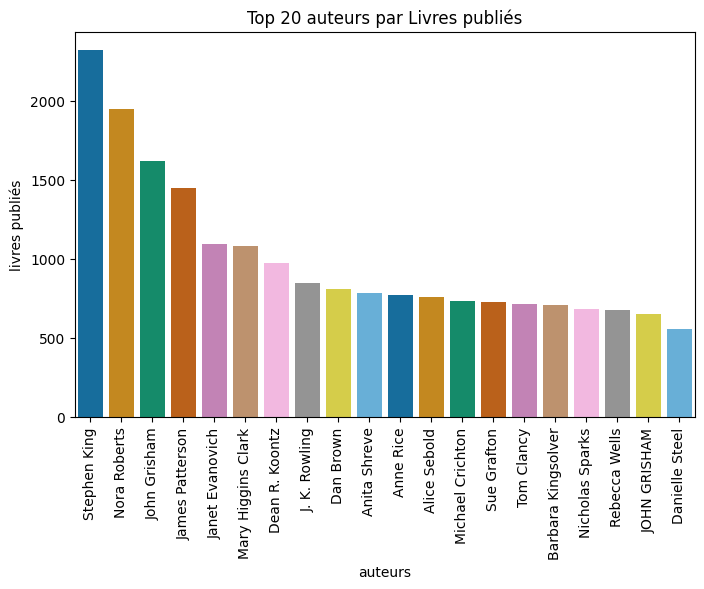

In [46]:
# Nombre de livres par auteur
authors_count = dataset.groupby("Book-Author")["Book-Title"].count().reset_index()

authors_count = authors_count.sort_values(by="Book-Title", ascending=False)
top_20_authors = authors_count.head(20)

# Visualisation avec Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=top_20_authors, x="Book-Author", y="Book-Title", palette="colorblind")
plt.title("Top 20 auteurs par Livres publiés")
plt.xlabel("auteurs")
plt.ylabel("livres publiés")
plt.xticks(rotation=90)
plt.show()